In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# Load both datasets
fake = pd.read_csv(r"C:\Users\adita\OneDrive\Desktop\Data_Science\Fake_news_predict\Fake.csv")
real = pd.read_csv(r"C:\Users\adita\OneDrive\Desktop\Data_Science\Fake_news_predict\True.csv")

In [6]:
# Add a 'label' column to each
fake['label'] = 0  # 0 for FAKE
real['label'] = 1  # 1 for REAL

In [7]:
# Combine them
df = pd.concat([fake, real], ignore_index=True)

In [8]:
# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
print(df.head())

                                               title  \
0  France expects slow but massive impact from la...   
1   Paul Ryan Just Gave The Most CRINGEWORTHY Res...   
2  PRESIDENT TRUMP CALLS OUT NATO MEMBERS Standin...   
3  EP #7: Patrick Henningsen LIVE with guest Shaw...   
4   ‘Family Values’ Republicans Introduce A Bill ...   

                                                text    subject  \
0  PARIS (Reuters) - President Emmanuel Macron s ...  worldnews   
1  President-elect Donald Trump has been a sore s...       News   
2  President Trump met for the first time with me...   politics   
3   Join Patrick every Wednesday at Independent T...    US_News   
4  You have to love the Republican party. They ca...       News   

                 date  label  
0  December 12, 2017       1  
1    December 5, 2016      0  
2        May 25, 2017      0  
3   December 29, 2016      0  
4     January 7, 2016      0  


In [17]:
print(df['label'].value_counts())  # Should show counts of FAKE and REAL

label
0    23481
1    21417
Name: count, dtype: int64


In [19]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df['text'] = df['text'].apply(clean_text)

In [20]:
# Split into training and testing sets
X = df['text']
y = df['label']

In [21]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

In [22]:
# Vectorize text using TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [23]:
# Train Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [24]:
# Predict on test data
y_pred = model.predict(X_test_tfidf)

In [25]:
# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      4696
           1       0.93      0.96      0.94      4284

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



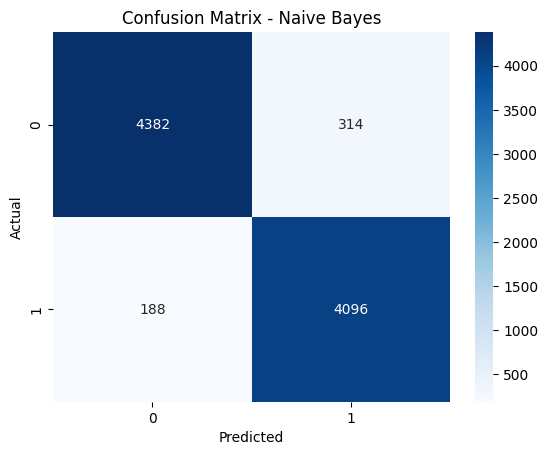

In [26]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

In [29]:
# Train the model
lr_model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [30]:
# Predict on test data
y_pred_lr = lr_model.predict(X_test_tfidf)

In [31]:
# Evaluate the model
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



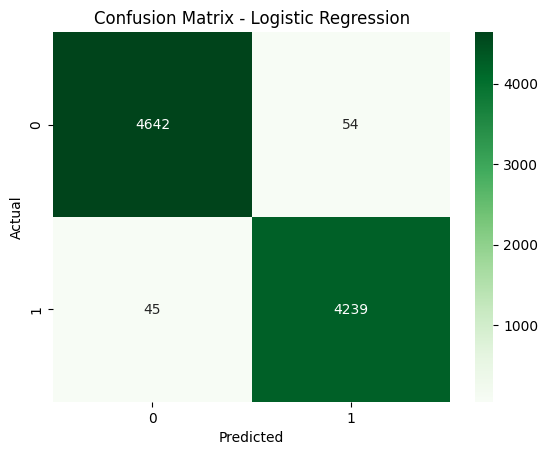

In [32]:
# Plot confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [33]:
import numpy as np
feature_names = tfidf.get_feature_names_out()
coefficients = lr_model.coef_[0]

In [34]:
# Get indices of top positive and negative coefficients
top_positive_indices = np.argsort(coefficients)[-10:]
top_negative_indices = np.argsort(coefficients)[:10]
print("Top words predicting REAL news:")
for i in reversed(top_positive_indices):
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")
print("\nTop words predicting FAKE news:")
for i in top_negative_indices:
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")

Top words predicting REAL news:
reuters: 29.4086
trumps: 11.8025
wednesday: 7.3831
washington: 7.1235
thursday: 6.4944
tuesday: 6.3768
monday: 5.8384
friday: 5.7938
minister: 5.1392
statement: 5.1284

Top words predicting FAKE news:
image: -6.6504
just: -6.3049
america: -5.4415
gop: -5.1466
don: -4.9994
wire: -4.9055
obama: -4.8741
hillary: -4.8161
doesn: -4.2785
didn: -4.2771


In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

In [36]:
y_prob = lr_model.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

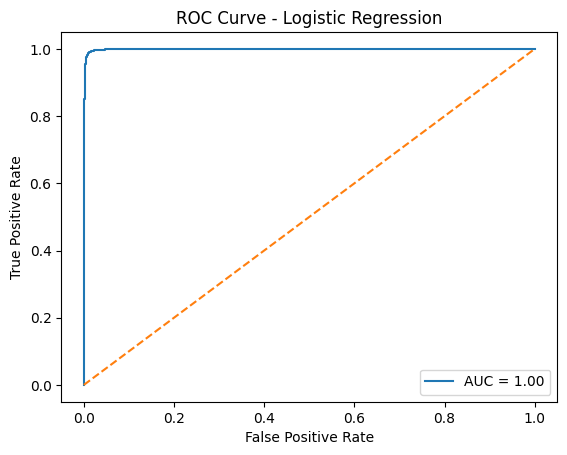

In [37]:
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()